In [ ]:
import gc

import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, PredefinedSplit, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

seed = 1234
np.random.seed(seed)

In [3]:
# for low memory VMs, rerunning this may require restarting the kernel
def load_imdb_dataset(get_vectorizer=False):
    dataset = load_dataset("imdb").shuffle(seed=seed)
    vectorizer = TfidfVectorizer().fit(dataset["train"]["text"])

    train_texts = vectorizer.transform(dataset["train"]["text"])
    train_labels = np.array(dataset["train"]["label"])

    test_texts = vectorizer.transform(dataset["test"]["text"])
    test_labels = np.array(dataset["test"]["label"])

    del dataset
    if not get_vectorizer:
        del vectorizer

    gc.collect()

    train_texts, valid_texts, train_labels, valid_labels = train_test_split(
        train_texts,
        train_labels,
        test_size=0.25,
        random_state=seed,
        stratify=train_labels
    )

    return (
        train_texts,
        train_labels,
        valid_texts,
        valid_labels,
        test_texts,
        test_labels
    ) if not get_vectorizer else (
        train_texts,
        train_labels,
        valid_texts,
        valid_labels,
        test_texts,
        test_labels,
        vectorizer
    )

In [4]:
# labels: 0 = negative review, 1 = positive review
train_X, train_y, valid_X, valid_y, test_X, test_y = load_imdb_dataset()

In [5]:
print(f"Train texts shape: {train_X.shape}")
print(f"Train labels shape: {train_y.shape}")
print(f"Valid texts shape: {valid_X.shape}")
print(f"Valid labels shape: {valid_y.shape}")
print(f"Test texts shape: {test_X.shape}")
print(f"Test labels shape: {test_y.shape}")

Train texts shape: (18750, 74849)
Train labels shape: (18750,)
Valid texts shape: (6250, 74849)
Valid labels shape: (6250,)
Test texts shape: (25000, 74849)
Test labels shape: (25000,)


## Finding the Critical Point

In [ ]:
def errors_for_train_sizes_mlp(X_tr, y_tr, X_te, y_te, seed, train_sizes):
    tr_err_mlp = []
    te_err_mlp = []
    for n in train_sizes:
        model = MLPClassifier(
            hidden_layer_sizes = (64, ),
            activation = 'relu',
            solver = 'sgd',
            learning_rate_init = 0.001,
            batch_size = 256,
            random_state = seed,
        )
        model.fit(X_tr[:n], y_tr[:n])
        tr_err_mlp.append(1 - model.score(X_tr[:n], y_tr[:n]))
        te_err_mlp.append(1 - model.score(X_te, y_te))
    return tr_err_mlp, te_err_mlp 

In [ ]:
def errors_for_train_sizes_lr(X_tr, y_tr, X_te, y_te, seed, train_sizes):    
    tr_err_lr = []
    te_err_lr = [] 
    for n in train_sizes:
        model = LogisticRegression(max_iter = 1000, random_state = seed)
        model.fit(X_tr[:n], y_tr[:n])
        tr_err_lr.append(1 - model.score(X_tr[:n], y_tr[:n]))
        te_err_lr.append(1 - model.score(X_te, y_te))
    return tr_err_lr, te_err_lr

In [ ]:
def plot_errors_for_train_sizes_mlp_lr(tr_err_mlp, te_err_mlp, tr_err_lr, te_err_lr, train_sizes):
    plt.figure(figsize = (10,6))
    plt.semilogx(train_sizes, tr_err_mlp, label = "tr_mlp", color = 'orange', marker = 'x')
    plt.semilogx(train_sizes, te_err_mlp, label = "te_mlp", color = 'orange', marker = 'x', linestyle = '--')
    plt.semilogx(train_sizes, tr_err_lr, label = "tr_lr", color = 'blue', marker = 'x')
    plt.semilogx(train_sizes, te_err_lr, label = "te_lr", color = 'blue', marker = 'x', linestyle = '--')

    plt.xlabel('Num. Training Data Points')
    plt.ylabel('Error Rate')
    plt.title('Training vs Testing Error for MLP and LR')
    plt.legend()
    plt.show()

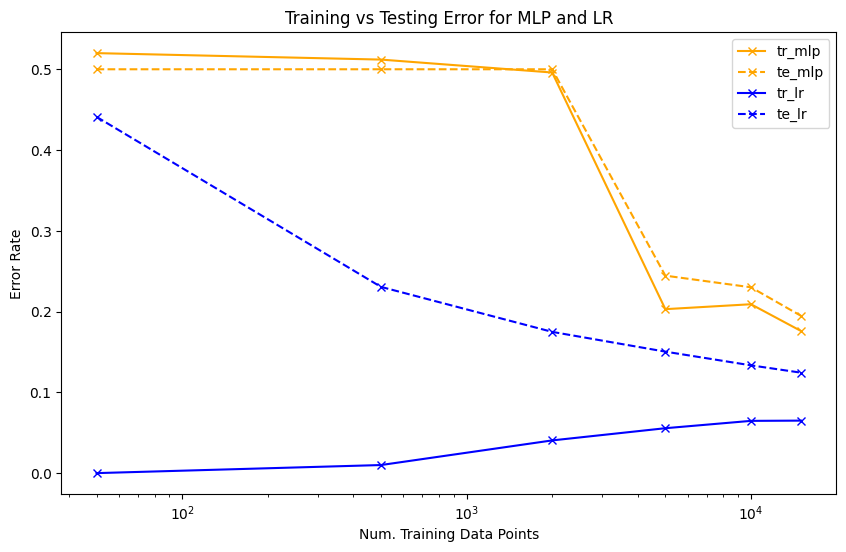

In [ ]:
train_sizes = [50, 500, 2000, 5000, 10000, 15000]
tr_err_mlp, te_err_mlp = errors_for_train_sizes_mlp(train_X, train_y, test_X, test_y, seed, train_sizes)
tr_err_lr, te_err_lr = errors_for_train_sizes_lr(train_X, train_y, test_X, test_y, seed, train_sizes)
plot_errors_for_train_sizes_mlp_lr(tr_err_mlp, te_err_mlp, tr_err_lr, te_err_lr, train_sizes)
# Takes 2hrs 10 mins to run

Based on the graph, it seems that the critical point for the MLP is at around 5,000 datapoints, since the error rates significantly drop and start to stabilize.

## Fine-Tuning the Hyperparameters (Individual)

In [6]:
def plot_errors(values, tr_err, val_err, te_err, x_axis_label):
    x = np.arange(len(values))
    width = 0.25 

    fig, ax = plt.subplots(figsize=(10,6))

    ax.bar(x - width, tr_err, width, label='Train Error')
    ax.bar(x, val_err, width, label='Validation Error')
    ax.bar(x + width, te_err, width, label='Test Error')

    ax.set_xlabel(x_axis_label)
    ax.set_ylabel('Error')
    ax.set_title(f'{x_axis_label} vs. Error')
    ax.set_xticks(x)
    ax.set_xticklabels(values)
    ax.legend()
    plt.show()

0.0001
0.001
0.005
0.01
0.05
0.1
0.15


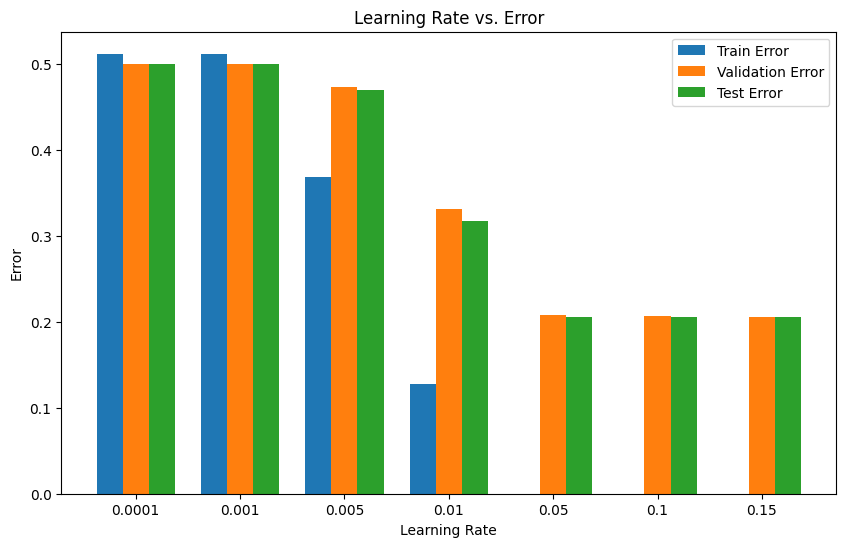

In [7]:
def test_learning_rates(X_tr: np.array, y_tr: np.array, X_te: np.array, y_te: np.array, seed: int, valid_X, valid_y, learning_rates):
    tr_err_mlp = []
    valid_err_mlp = []
    te_err_mlp = []
    for lr in learning_rates:
        print(f"{lr}")
        model = MLPClassifier(
            hidden_layer_sizes = (64, ),
            activation = 'relu',
            solver = 'sgd',
            learning_rate_init = lr,
            batch_size = 256,
            random_state = seed,
        )
        model.fit(X_tr[:500], y_tr[:500])
        tr_err_mlp.append(1 - model.score(X_tr[:500], y_tr[:500]))
        valid_err_mlp.append(1 - model.score(valid_X, valid_y))
        te_err_mlp.append(1 - model.score(X_te, y_te))
    return tr_err_mlp, valid_err_mlp, te_err_mlp 

learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.15]
tr_err_mlp, valid_err_mlp, te_err_mlp = test_learning_rates(train_X, train_y, test_X, test_y, seed, valid_X, valid_y, learning_rates)
plot_errors(learning_rates, tr_err_mlp, valid_err_mlp, te_err_mlp, 'Learning Rate')

adam
sgd
lbfgs


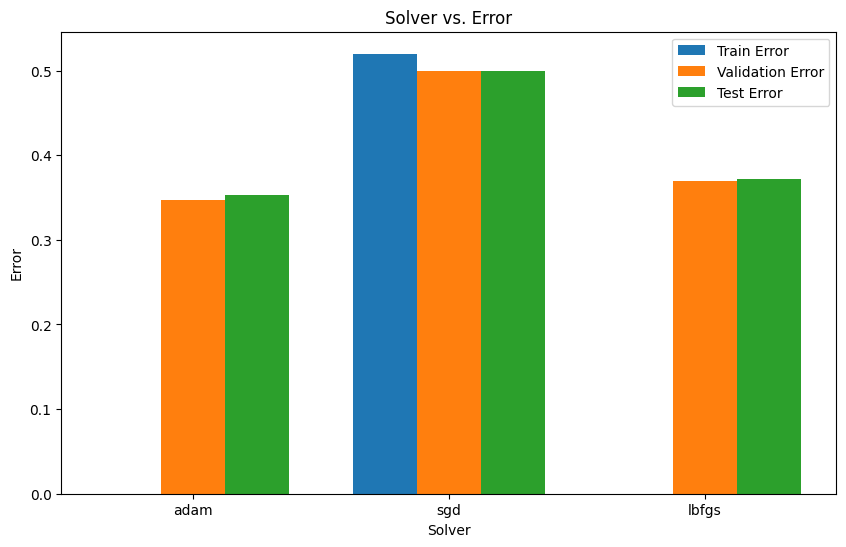

In [ ]:
def test_solvers(X_tr: np.array, y_tr: np.array, X_te: np.array, y_te: np.array, seed: int, valid_X, valid_y, solvers):
    tr_err_mlp = []
    valid_err_mlp = []
    te_err_mlp = []
    for s in solvers:
        print(f"{s}")
        model = MLPClassifier(
            hidden_layer_sizes = (64, ),
            activation = 'relu',
            solver = s,
            batch_size = 256,
            random_state = seed,
        )
        model.fit(X_tr[:50], y_tr[:50])
        tr_err_mlp.append(1 - model.score(X_tr[:50], y_tr[:50]))
        valid_err_mlp.append(1 - model.score(valid_X, valid_y))
        te_err_mlp.append(1 - model.score(X_te, y_te))
    return tr_err_mlp, valid_err_mlp, te_err_mlp 

solvers = ['adam', 'sgd', 'lbfgs']
tr_err_mlp, valid_err_mlp, te_err_mlp = test_solvers(train_X, train_y, test_X, test_y, seed, valid_X, valid_y, solvers)
plot_errors(solvers, tr_err_mlp, valid_err_mlp, te_err_mlp, 'Solver')

relu
tanh
logistic
identity


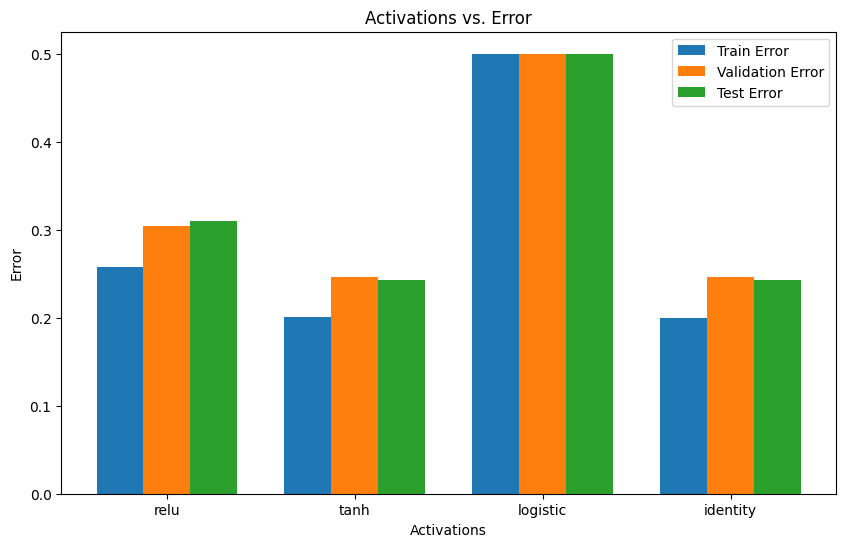

In [35]:
def test_activations(X_tr: np.array, y_tr: np.array, X_te: np.array, y_te: np.array, seed: int, valid_X, valid_y, activations):
    tr_err_mlp = []
    valid_err_mlp = []
    te_err_mlp = []
    for a in activations:
        print(f"{a}")
        model = MLPClassifier(
            hidden_layer_sizes = (64, ),
            activation = a,
            solver = 'sgd',
            batch_size = 256,
            random_state = seed,
        )
        model.fit(X_tr[:5000], y_tr[:5000])
        tr_err_mlp.append(1 - model.score(X_tr[:5000], y_tr[:5000]))
        valid_err_mlp.append(1 - model.score(valid_X, valid_y))
        te_err_mlp.append(1 - model.score(X_te, y_te))
    return tr_err_mlp, valid_err_mlp, te_err_mlp 

activations = ['relu', 'tanh', 'logistic', 'identity']
tr_err_mlp, valid_err_mlp, te_err_mlp = test_activations(train_X, train_y, test_X, test_y, seed, valid_X, valid_y, activations)
plot_errors(activations, tr_err_mlp, valid_err_mlp, te_err_mlp, 'Activations')

32
64
128
256
512
1024


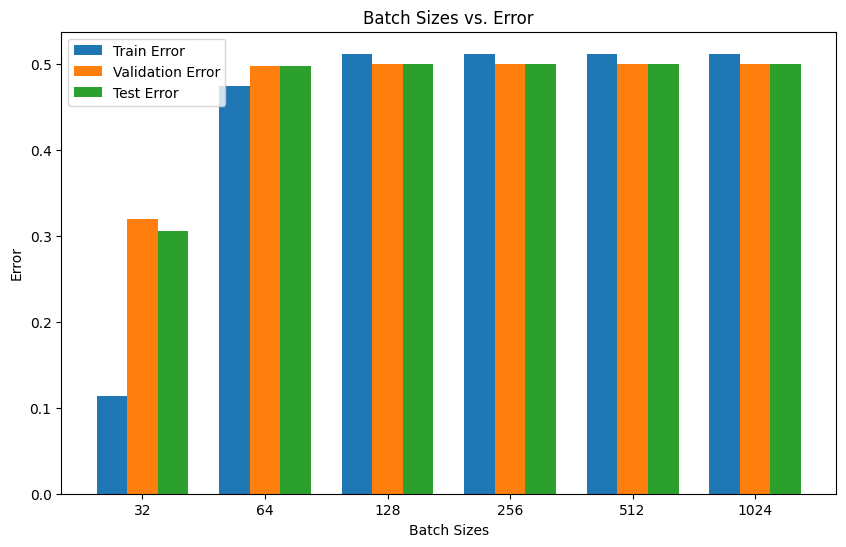

In [16]:
def test_batch_sizes(X_tr: np.array, y_tr: np.array, X_te: np.array, y_te: np.array, seed: int, valid_X, valid_y, sizes):
    tr_err_mlp = []
    valid_err_mlp = []
    te_err_mlp = []
    for size in sizes:
        print(f"{size}")
        model = MLPClassifier(
            hidden_layer_sizes = (64, ),
            activation = 'relu',
            solver = 'sgd',
            batch_size = size,
            random_state = seed,
        )
        model.fit(X_tr[:500], y_tr[:500])
        tr_err_mlp.append(1 - model.score(X_tr[:500], y_tr[:500]))
        valid_err_mlp.append(1 - model.score(valid_X, valid_y))
        te_err_mlp.append(1 - model.score(X_te, y_te))
    return tr_err_mlp, valid_err_mlp, te_err_mlp 

sizes = [32, 64, 128, 256, 512, 1024]
tr_err_mlp, valid_err_mlp, te_err_mlp = test_batch_sizes(train_X, train_y, test_X, test_y, seed, valid_X, valid_y, sizes)
plot_errors(sizes, tr_err_mlp, valid_err_mlp, te_err_mlp, 'Batch Sizes')

Based on these tests, it seems that the best hyperparameters to use are as follows:

Learning_rate_init = 0.05, 0.1, 0.15 (all work equally well)
Solver: adam
Activation: tanh
Batch_size: 32

## Combining Optimal Hyperparameters

Though the individual parameters do well on their own, sometimes combining them in a model doesn't produce the most optimal output. This section covers different combinations of the hyperparameters above with a few additional tweaks.

In [25]:
# Trying all "optimal" parameters together

model = MLPClassifier(
    activation = 'tanh',
    solver = 'adam',
    batch_size = 32,
    learning_rate_init = 0.05,
    random_state = seed,
    max_iter = 6,
    verbose = True
)
model.fit(train_X[:5000], train_y[:5000])
training_error = 1 - model.score(train_X[:5000], train_y[:5000])
validation_error = 1 - model.score(valid_X, valid_y)
testing_error = 1 - model.score(test_X, test_y)

print(f"Training Error: {training_error}")
print(f"Validation Error: {validation_error}")
print(f"Testing Error: {testing_error}")


Iteration 1, loss = 0.61725467
Iteration 2, loss = 0.29495057
Iteration 3, loss = 0.37297658
Iteration 4, loss = 0.40031814
Iteration 5, loss = 0.33279651
Iteration 6, loss = 0.27196962
Training Error: 0.009399999999999964
Validation Error: 0.18159999999999998
Testing Error: 0.1834


In [ ]:
# Using adam/relu combination

model = MLPClassifier(
    activation = 'relu',
    solver = 'adam',
    batch_size = 32,
    learning_rate_init = 0.05,
    random_state = seed,
    max_iter = 6,
    verbose = True
)
model.fit(train_X[:5000], train_y[:5000])
training_error = 1 - model.score(train_X[:5000], train_y[:5000])
validation_error = 1 - model.score(valid_X, valid_y)
testing_error = 1 - model.score(test_X, test_y)

print(f"Training Error: {training_error}")
print(f"Validation Error: {validation_error}")
print(f"Testing Error: {testing_error}")

Iteration 1, loss = 0.49772159
Iteration 2, loss = 0.17616359
Iteration 3, loss = 0.14952524
Iteration 4, loss = 0.21303696
Iteration 5, loss = 0.20206484
Iteration 6, loss = 0.18965040
Training Error: 0.0043999999999999595
Validation Error: 0.16879999999999995
Testing Error: 0.16996


In [ ]:
# Using a different hidden layer size (default is 100) 

model = MLPClassifier(
    hidden_layer_sizes = (64, ),
    activation = 'relu',
    solver = 'adam',
    batch_size = 32,
    learning_rate_init = 0.05,
    random_state = seed,
    max_iter = 6,
    verbose = True
)
model.fit(train_X[:5000], train_y[:5000])
training_error = 1 - model.score(train_X[:5000], train_y[:5000])
validation_error = 1 - model.score(valid_X, valid_y)
testing_error = 1 - model.score(test_X, test_y)

print(f"Training Error: {training_error}")
print(f"Validation Error: {validation_error}")
print(f"Testing Error: {testing_error}")

Iteration 1, loss = 0.48448076
Iteration 2, loss = 0.17192527
Iteration 3, loss = 0.15414837
Iteration 4, loss = 0.19867781
Iteration 5, loss = 0.24582893
Iteration 6, loss = 0.22378421
Training Error: 0.0023999999999999577
Validation Error: 0.16400000000000003
Testing Error: 0.16844000000000003


In [16]:
# Using a larger batch size, increasing max_iter

model = MLPClassifier(
    hidden_layer_sizes = (64, ),
    activation = 'relu',
    solver = 'adam',
    batch_size = 128,
    learning_rate_init = 0.05,
    random_state = seed,
    max_iter = 10,
    verbose = True
)
model.fit(train_X[:5000], train_y[:5000])
training_error = 1 - model.score(train_X[:5000], train_y[:5000])
validation_error = 1 - model.score(valid_X, valid_y)
testing_error = 1 - model.score(test_X, test_y)

print(f"Training Error: {training_error}")
print(f"Validation Error: {validation_error}")
print(f"Testing Error: {testing_error}")

Iteration 1, loss = 0.43197735
Iteration 2, loss = 0.06506158
Iteration 3, loss = 0.03546195
Iteration 4, loss = 0.02558928
Iteration 5, loss = 0.01966961
Iteration 6, loss = 0.01537000
Iteration 7, loss = 0.01246627
Iteration 8, loss = 0.01018285
Iteration 9, loss = 0.00869431
Iteration 10, loss = 0.00766982
Training Error: 0.0
Validation Error: 0.14159999999999995
Testing Error: 0.14344


After testing different combinations, it seems that the best parameters are as follows:
hidden_layer_size = (64, ), activation = relu, solver = adam, batch_size = 128, learning_rate_init = 0.05, max_iter = 10

## Individual vs Group hyperparameters

In [21]:
def plot_model_errors(mlp1_errors, mlp2_errors):
    labels = ['Training', 'Validation', 'Test']
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    bar1 = ax.bar(x - width/2, mlp1_errors, width, label = 'Individual')
    bar2 = ax.bar(x + width/2, mlp2_errors, width, label = 'Group')

    ax.set_ylabel('Error')
    ax.set_title('MLP Error Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


Iteration 1, loss = 0.61725467
Iteration 2, loss = 0.29495057
Iteration 3, loss = 0.37297658
Iteration 4, loss = 0.40031814
Iteration 5, loss = 0.33279651
Iteration 6, loss = 0.27196962
Iteration 1, loss = 0.43197735
Iteration 2, loss = 0.06506158
Iteration 3, loss = 0.03546195
Iteration 4, loss = 0.02558928
Iteration 5, loss = 0.01966961
Iteration 6, loss = 0.01537000
Iteration 7, loss = 0.01246627
Iteration 8, loss = 0.01018285
Iteration 9, loss = 0.00869431
Iteration 10, loss = 0.00766982


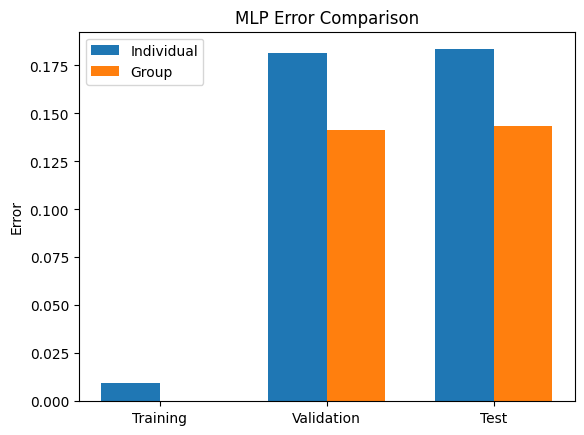

In [ ]:
indv_errors = []
group_errors = []

individual_model = MLPClassifier(
    activation = 'tanh',
    solver = 'adam',
    batch_size = 32,
    learning_rate_init = 0.05,
    random_state = seed,
    max_iter = 6,
    verbose = True
)
individual_model.fit(train_X[:5000], train_y[:5000])
indv_errors.append(1 - individual_model.score(train_X[:5000], train_y[:5000]))
indv_errors.append(1 - individual_model.score(valid_X, valid_y))
indv_errors.append(1 - individual_model.score(test_X, test_y))


group_model = MLPClassifier(
    hidden_layer_sizes = (64, ),
    activation = 'relu',
    solver = 'adam',
    batch_size = 128,
    learning_rate_init = 0.05,
    random_state = seed,
    max_iter = 10,
    verbose = True
)
group_model.fit(train_X[:5000], train_y[:5000])
group_errors.append(1 - group_model.score(train_X[:5000], train_y[:5000]))
group_errors.append(1 - group_model.score(valid_X, valid_y))
group_errors.append(1 - group_model.score(test_X, test_y))

plot_model_errors(indv_errors, group_errors)
